# Vision Transformer (ViT)

El Vision Transformer (ViT), propuesto por Dosovitskiy et al. (2020), utiliza una arquitectura basada en Transformers para tareas de visión por computadora. A diferencia de las CNN, el ViT aplica **Multi-Head Self-Attention (MHSA)** para modelar relaciones globales entre partes de la imagen.

## Arquitectura

El ViT divide las imágenes en **patches** y las convierte en una secuencia de vectores de características (embeddings), que luego se procesan mediante capas Transformer. A continuación, se aplica el mecanismo de self-attention para modelar las relaciones entre estos patches.

- **Embeddings**: Cada parche se aplana y se proyecta en un espacio de mayor dimensión.
- **Positional Encoding**: Se agrega un embebido posicional para cada parche, permitiendo que el modelo capture las posiciones espaciales.
---
## ¿Cómo funciona el Self-Attention en ViT?

Cada uno de los parches se considera un token similar a las palabras en el procesamiento del lenguaje natural (NLP).
En el mecanismo de Self-Attention, cada uno de estos tokens (parches) puede interactuar con los demás tokens. Para hacerlo, el modelo calcula tres vectores para cada token: 

- **Query:** Representa qué está buscando el token.

- **Key:** Representa una descripción de los demás tokens.

- **Value:** Es la información que tiene cada token y que podría ser relevante para otros tokens.

Luego, se calculan las similitudes entre el *Query* de un token y el *Key* de todos los demás tokens, lo que genera una "puntuación de atención". Esta puntuación determina cuánta atención debe prestar un token a otros. El valor *Value* de cada token se pondera según esta puntuación, lo que permite que un token integre información de todo el resto de la imagen.

Este mecanismo es lo que permite que cada token (parche) en una imagen entienda no solo lo que está ocurriendo en su área local, sino también pueda considerar qué está sucediendo en otras partes de la imagen. 

La fórmula utilizada para calcular la atención es:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

Donde:
- **$Q$ (queries)**, **$K$ (keys)**, y **$V$ (values)** son las proyecciones lineales de los embeddings de los patches.
- **$d_k$** es la dimensionalidad de las proyecciones, usada para escalar el producto punto y estabilizar el entrenamiento.

Este proceso se aplica en múltiples cabezas, lo que permite al modelo aprender distintas representaciones.

El mecanismo de self-attention utiliza las proyecciones:

$$Q = XW_Q, \quad K = XW_K, \quad V = XW_V$$

Donde $X$ es el input y $W_Q$, $W_K$, y $W_V$ son matrices de pesos aprendidos.

Después de aplicar el mecanismo de Self-Attention, los tokens se actualizan, ya que ahora tienen información de los demás tokens. Este proceso se repite varias veces en distintas capas de atención, profundizando la interacción entre los parches.

Salida Final: Después de aplicar múltiples capas de Self-Attention, el modelo agrupa los tokens procesados para predecir la clase de la imagen o realizar otras tareas de visión.


![Vision Transformer](vit_gif.gif)

*Crédito: [lucidrains](https://github.com/lucidrains/vit-pytorch)*


## Tareas:

1. **Implementar la arquitectura de un Vision Transformer** 

2. **Ingresar y ajustar los parametros del modelo***

3. **Probar diferentes técnicas de data augmentation** 

In [1]:
import os
os.environ["TORCH_INDUCTOR_ENABLED"] = "0"

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import numpy as np
import math
import os
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch
from torchvision import datasets, transforms
import torch._dynamo
torch._dynamo.config.suppress_errors = True
from trainer import Trainer



device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print('Dispositivo: ',device)
print('Torch version: ',torch.__version__)

# La configuración, carga y preprocesamiento
class ConfigPreprocess:
    def __init__(self, device: str, img_path: str, img_size: int, patch_size: int):
        self.device = device
        self.img_path = img_path
        self.img_size = img_size
        self.patch_size = patch_size
        self.test_img = self.load_image()

    def load_image(self):
        return TF.to_tensor(Image.open(self.img_path).resize((self.img_size, self.img_size))).unsqueeze(0).to(self.device)

    def extract_patches(self, image: Tensor) -> Tensor:
        patches = image.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(image.shape[0], -1, self.patch_size, self.patch_size)
        return patches
    

class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class PositionalEncodingLearned(nn.Module):
    """Codigo que proviene del TP1."""
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncodingLearned, self).__init__()
        # Aqui no uso register_buffer porque quiero que justamente este parámetro sea entrenable
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        return x + self.pos_embedding



# Parámetros
img_path = "raccoon.jpg"
img_size = 900
patch_size = 64
embed_dim = 8
patch_idx = 0  # El índice del parche para el cual queres visualiizar la codificación posicional

# Preprocesamiento
config = ConfigPreprocess(device,img_path, img_size, patch_size)

# Extracción de parches y visualización
patches = config.extract_patches(config.test_img.squeeze(0))

# Generación de embeddings
embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional

num_patches = (img_size // patch_size) ** 2
try:
    positional_encoding = PositionalEncodingLearned(num_patches, embed_dim).to(config.device)
    pos_embeddings = positional_encoding(patches)

except Exception as e:
    print(f"Revise la existencia de la función PositionalEncodingLearned. Se produjo error durante la compilación: \n {e}.")


Dispositivo:  cuda
Torch version:  2.5.1+cu124


# Transformer Encoder

In [3]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, num_layers: int, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout,bias= False)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
    def forward(self, x):
        return self.transformer_encoder(x)

# Vision Transformer
Model
> 
```ViT-Base ViT-Large ViT-Huge
    Layers Hidden size D 12 768
    24 1024 32 1280
    MLP size Heads
    Params
    3072 12 86M 4096 16 307M 5120 16 632M
```


In [4]:
class VisionTransformer(nn.Module):
    """Estructura del ViT."""

    def __init__(self, img_size, patch_size, embed_dim, num_heads, ff_dim, num_layers, num_classes=10, dropout=0.1,batch_first=True):
        super().__init__()

        # Embedding de los patches
        self.patch_embedding = PatchEmbedding(img_size, patch_size, 3, embed_dim) #3 porque son siempre imagenes RGB
        num_patches = (img_size // patch_size) ** 2

        # Token [CLS] que será el vector de clasificación
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        # Codificación posicional, incluyendo el token [CLS]
        self.positional_encoding = PositionalEncodingLearned(num_patches + 1, embed_dim)

        # Capa de Transformer Encoder que proviene de la celda anterior
        self.transformer_encoder = TransformerEncoder(embed_dim, num_heads, ff_dim, num_layers, dropout=dropout)

        # MLP para la clasificación final
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),  # Normalización LayerNorm
            nn.Linear(embed_dim, num_classes),  # Capa final para clasificar
            nn.Dropout(dropout)  # Dropout antes de la salida
        )

    def forward(self, x):
        B = x.shape[0]  # Tamaño del batch

        # Obtener los embeddings de los patches
        patches = self.patch_embedding(x)  # (B, num_patches, embed_dim)

        # Expandir el token [CLS] para cada imagen en el batch
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)

        # Concatenar el token [CLS] con los patches
        x = torch.cat((cls_tokens, patches), dim=1)  # (B, 1 + num_patches, embed_dim)

        # Aplicar la codificación posicional
        x = self.positional_encoding(x)

        # Pasar por el Transformer Encoder
        x = self.transformer_encoder(x)  # (B, 1 + num_patches, embed_dim)

        # Extraer la salida del token [CLS] (primera posición)
        cls_output = x[:, 0]  # (B, embed_dim)

        # Pasar por el MLP para obtener la predicción final
        out = self.mlp_head(cls_output)  # (B, num_classes)

        return out


# CIFAR10

In [5]:

# Define transformations for the input data
transform = transforms.Compose([
    #transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def get_folder_size(folder_path :os.PathLike) -> str:
    total_size = 0
    for dirpath, _, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)

            if not os.path.islink(file_path):
                total_size += os.path.getsize(file_path)

    if total_size == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB")
    i = int(math.floor(math.log(total_size, 1024)))
    p = math.pow(1024, i)
    s = round(total_size / p, 2)
    return f"{s} {size_name[i]}"


folder_path = './data'
size_in_bytes = get_folder_size(folder_path)
print(f"Tamaño de carpeta: {size_in_bytes}")

Tamaño de carpeta: 340.19 MB


# Modelo

In [7]:
num_epochs = 30

model = VisionTransformer(
    img_size=32,
    patch_size=4,
    embed_dim=128, 
    num_heads=8, 
    ff_dim=256, 
    num_layers=5,
    num_classes=10, #Cifar10
    dropout=0.05,
    batch_first=True
).to(device)


print("Parametros del modelo:", list(model.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)


model = model.to(device)


try:
    model = torch.compile(model)
except Exception as e:
    print("Se produjo error durante la compilación:", e)


/home/idk/git/vision_transformers_fiuba/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Parametros del modelo: [Parameter containing:
tensor([[[ 3.6927e-01,  1.1492e+00,  2.3284e+00,  6.0791e-01, -3.2050e-01,
          -3.0626e-01,  4.9534e-01,  1.4298e-01, -7.1541e-01,  2.3658e+00,
           1.6258e+00, -3.8217e-01, -6.6855e-01,  5.7655e-01,  9.1082e-01,
          -2.8464e+00, -3.2988e-01,  2.5041e-02,  1.5431e+00,  3.7447e-01,
           5.0246e-01,  2.2389e+00, -8.0014e-01,  9.1665e-02, -1.3085e+00,
          -2.1487e-01,  4.6034e-01, -4.5782e-01, -9.5169e-01,  1.4809e+00,
          -1.1088e+00,  6.9113e-01,  2.1815e+00, -2.2423e+00,  1.5862e+00,
           9.2828e-01, -4.3348e-01, -3.3063e-02,  6.3914e-01,  2.3910e-03,
          -5.3260e-01,  1.4134e+00, -5.0424e-01,  4.9684e-01,  6.0302e-01,
          -1.0061e+00,  5.3003e-02, -8.0400e-02, -7.5612e-01, -2.4578e-01,
           5.5108e-01,  1.7012e+00, -1.0451e+00,  7.3622e-02,  2.0925e-01,
          -8.1429e-01, -4.4142e-01, -1.5382e+00,  2.0624e+00,  1.3818e+00,
          -6.3113e-01,  5.2924e-01, -1.5200e-01, -7.36

In [8]:
def count_parameters(model: nn.Module) -> int:
    """
    Count the number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        int: The total number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000

torch.cuda.empty_cache()
print("Número de parámetros: {:.2f} millones".format(count_parameters(model)))

Número de parámetros: 0.67 millones


In [9]:
print(torch.__version__)

2.5.1+cu124


In [10]:
# Deshabilito torch dynamo para poder usar en GPUs más viejas (en mi caso NVIDIA quadro k620)
torch._dynamo.config.dynamic_shapes = False
# torch._dynamo.config.enable_dynamic_shapes = False

In [24]:
trainer = Trainer(model, train_loader,test_loader,criterion,optimizer, device)


for epoch in range(num_epochs):

    trainer.train_model(use_amp=False)
    
    scheduler.step()

loss 2.30978: 100%|██████████| 782/782 [03:20<00:00,  3.90it/s]


In [67]:
def evaluate_model(model, data_loader):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images = images.to(device).float()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    return accuracy, precision, recall, f1

# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)


100%|██████████| 157/157 [00:16<00:00,  9.35it/s]
/home/idk/git/vision_transformers_fiuba/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.10
Precision: 0.01
Recall: 0.10
F1 score: 0.02


In [27]:
train_dataset.data[0].shape

(32, 32, 3)

  0%|          | 0/157 [00:00<?, ?it/s]


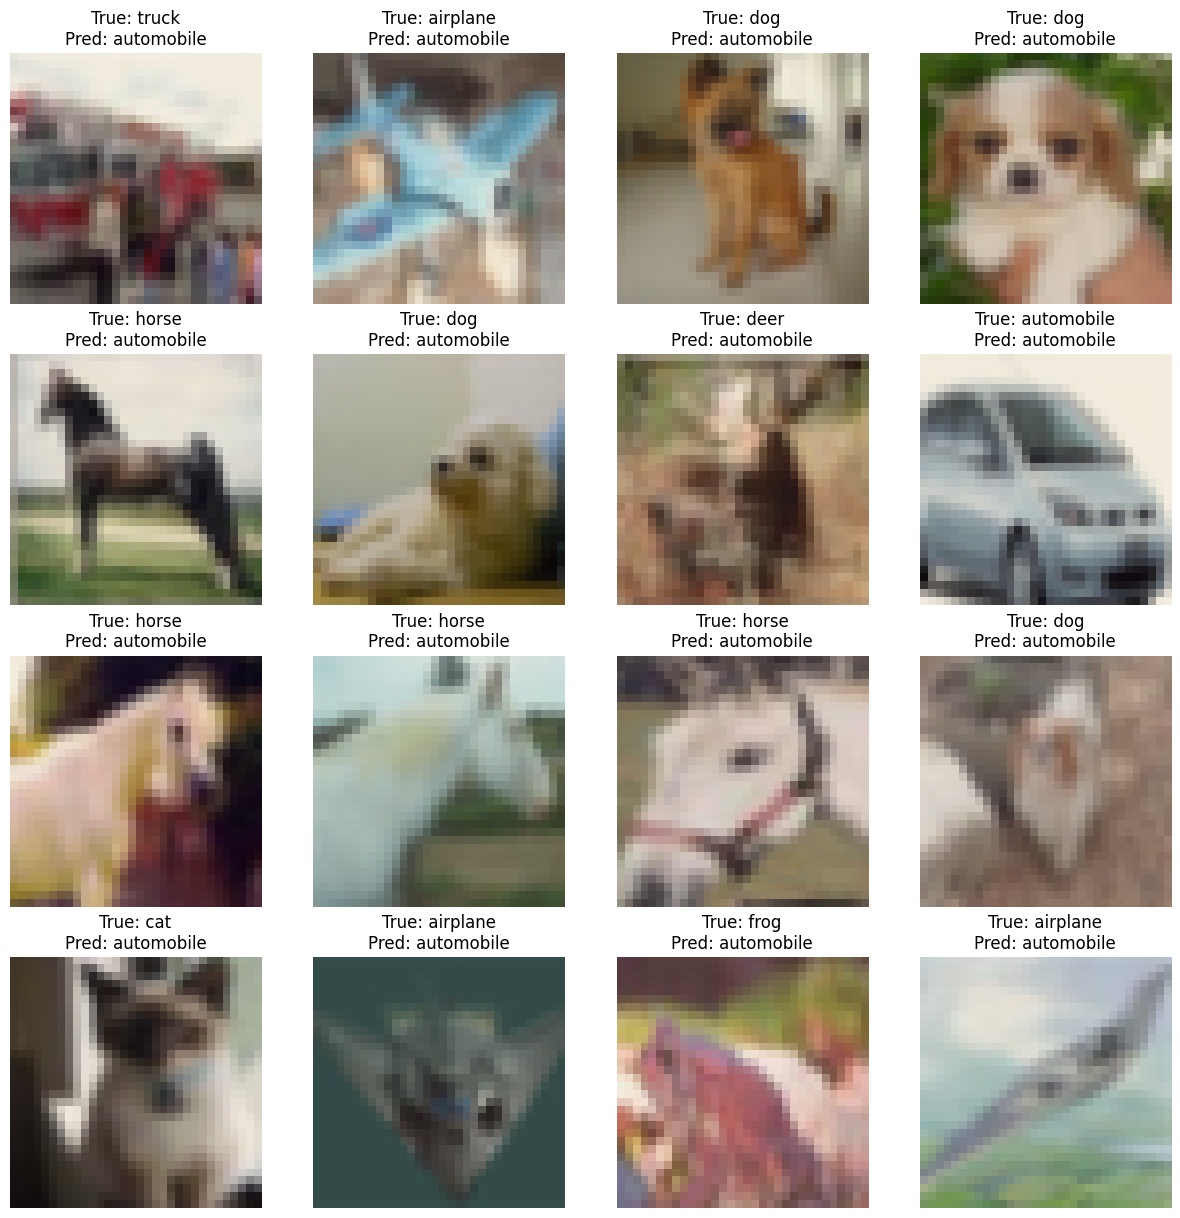

: 

In [28]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

def visualize_classification(model, data_loader, class_names, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(data_loader)):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'True: {class_names[labels[j]]}\nPred: {class_names[preds[j]]}')
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    return


visualize_classification(model, test_loader, class_names, num_images=16)
plt.show()


- Vemos que la performance es bastante pobre (solo 10%).
    - El modelo predice siempre la misma clase, sin importar la imagen (la salida es siempre automobile).
- Probemos qué pasa cambiando:
    - Las transformaciones de data augmentation.
    - Los parámetros de instanciación del modelo.

#### Cambiando transformaciones de data augmentation

In [59]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.07)),
])

# Train y test dataloaders
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


Visualizo transformaciones

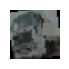

In [62]:
# Denormalize function
def denormalize(img, mean, std):
    img = img.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)  # Reverse normalization: img = img * std + mean
    return img

# Saco una imagen del batch del test_loader
data_iter = iter(test_loader)
images, labels = next(data_iter)

image = images[0]  # Shape: (3, 32, 32)

# Denormalización
mean = [0.49139968, 0.48215841, 0.44653091]
std = [0.24703223, 0.24348513, 0.26158784]
image_denorm = denormalize(image, mean, std)

# Transpose (32, 32, 3)
image_denorm = image_denorm.permute(1, 2, 0)

# Plot
plt.figure(figsize=(32/50, 32/50))  
plt.imshow(image_denorm)
plt.axis('off') 
plt.show()

Vuelvo a instanciar el modelo y entrenar

In [63]:
model = VisionTransformer(
    img_size=32,
    patch_size=4,
    embed_dim=128, 
    num_heads=8, 
    ff_dim=256, 
    num_layers=5,
    num_classes=10, #Cifar10
    dropout=0.05,
    batch_first=True
).to(device)


print("Parametros del modelo:", list(model.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)


model = model.to(device)


try:
    model = torch.compile(model)
except Exception as e:
    print("Se produjo error durante la compilación:", e)


Parametros del modelo: [Parameter containing:
tensor([[[ 1.0994e-01, -1.1986e+00, -5.1496e-01, -2.0931e-01,  7.0049e-04,
          -2.8194e-01,  5.1082e-01, -1.1635e+00,  4.2580e-01,  1.2865e+00,
           6.0903e-01,  1.0182e+00,  2.6705e-01, -1.5878e+00,  1.3239e+00,
          -4.8082e-01,  6.1178e-01, -8.9949e-01,  3.0779e-01,  5.6675e-01,
           5.1919e-01, -4.7960e-01,  1.8595e+00,  1.2529e+00, -2.0057e+00,
           1.1908e+00,  5.5282e-01, -4.5367e-01, -3.0197e-01, -5.1015e-01,
          -7.4765e-01,  5.9998e-01,  4.7500e-01, -2.6234e-01, -1.3084e+00,
           1.1526e+00,  4.5126e-02, -1.7147e-01,  1.1415e-01,  5.0285e-01,
           3.7307e-01,  2.0521e+00,  1.4769e-01, -6.6923e-01,  4.1226e-01,
          -1.5308e-01,  3.1904e-01,  1.3798e+00, -9.2731e-01,  1.8607e+00,
           1.5112e+00,  1.5420e+00,  7.0976e-01,  1.5647e-01, -1.9253e+00,
          -2.9729e-01, -1.4487e+00,  7.1789e-01,  6.0002e-02, -1.2730e+00,
           1.0108e+00,  7.0109e-01, -1.3633e+00,  1.12

/home/idk/git/vision_transformers_fiuba/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [66]:
num_epochs = 30

trainer = Trainer(model, train_loader,test_loader,criterion,optimizer, device)


for epoch in range(num_epochs):

    trainer.train_model(use_amp=False)
    
    scheduler.step()

loss 2.28177: 100%|██████████| 782/782 [02:43<00:00,  4.78it/s]


In [68]:
# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

100%|██████████| 157/157 [00:16<00:00,  9.31it/s]

Accuracy: 0.10
Precision: 0.01
Recall: 0.10
F1 score: 0.02



/home/idk/git/vision_transformers_fiuba/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Instanciando el modelo con otros parámetros

In [69]:
model_2 = VisionTransformer(
    img_size=32,
    patch_size=2,
    embed_dim=256, 
    num_heads=8, 
    ff_dim=1024, 
    num_layers=5,
    num_classes=10, #Cifar10
    dropout=0.15,
    batch_first=True
).to(device)


print("Parametros del modelo:", list(model_2.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_2.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)


model_2 = model_2.to(device)


try:
    model_2 = torch.compile(model_2)
except Exception as e:
    print("Se produjo error durante la compilación:", e)


/home/idk/git/vision_transformers_fiuba/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Parametros del modelo: [Parameter containing:
tensor([[[-1.5302, -0.4436, -0.6127,  0.8769,  0.0105, -0.3295, -0.9477,
           0.8237,  2.5307, -0.7143, -0.0621,  0.3651, -0.7345,  0.2822,
           0.3432, -1.4404, -0.1701, -0.9742,  0.3764, -1.5393, -0.1675,
           1.1286,  0.7605, -0.5294,  0.5824, -0.6629,  1.6949, -0.2297,
           1.1104,  0.9810,  1.3315, -0.7157,  0.4630,  0.5887, -0.7437,
          -0.0741,  0.6649,  1.1842, -0.7007,  0.3174, -0.1267, -0.5493,
           0.2277, -0.4218, -0.0654, -0.6758, -1.7580, -1.3269, -0.3461,
           0.6766,  0.2565,  0.6260, -0.1545,  0.2506,  0.5421, -1.3948,
          -0.4599, -0.3477, -0.5896,  2.0242,  0.2950,  1.1110, -0.6309,
           0.6121, -1.2512,  0.3792, -1.1342,  0.3443,  0.7835, -1.4275,
          -0.4324,  1.3520, -0.6094, -0.2467, -1.4999, -0.8160,  1.7219,
          -0.0645, -0.1868, -1.1690,  1.3174,  0.3038,  1.3647, -0.7222,
          -0.2542,  0.2044,  1.6425, -0.5989,  0.0140, -0.0538,  0.7268,
     

In [70]:
num_epochs = 30

trainer = Trainer(model_2, train_loader,test_loader,criterion,optimizer, device)


for epoch in range(num_epochs):

    trainer.train_model(use_amp=False)
    
    scheduler.step()

loss 2.30171:  83%|████████▎ | 647/782 [5:41:11<1:11:11, 31.64s/it]


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Nuevamente se ve que la pérdida se mantiene en 2.3

In [ ]:
# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(model_2, test_loader)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")